In [1]:
pip install tensorflow

In [15]:
from google.colab import files
uploaded = files.upload()

Saving content_image.jpg to content_image (3).jpg
Saving style_image.jpg to style_image (2).jpg


In [18]:
uploaded.keys()  # This will show the names of the uploaded files

dict_keys(['content_image (3).jpg', 'style_image (2).jpg'])

Saving content_image.jpg to content_image (4).jpg
Saving style_image.jpg to style_image (3).jpg


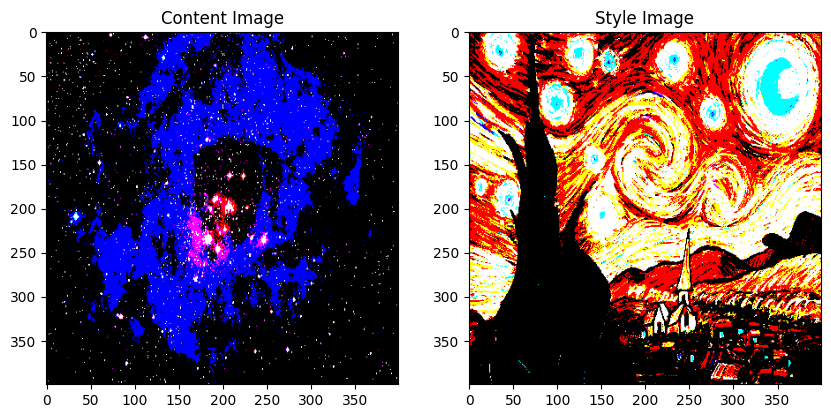

Epoch 1/10, Loss: 7.942553140681769e+17


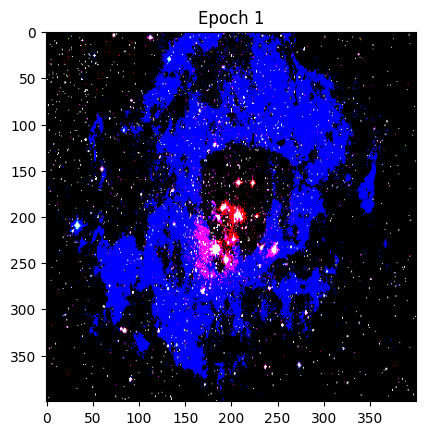

Epoch 2/10, Loss: 7.933051298633482e+17


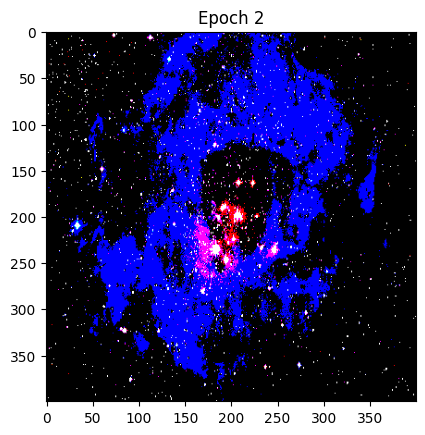

Epoch 3/10, Loss: 7.92356113889624e+17


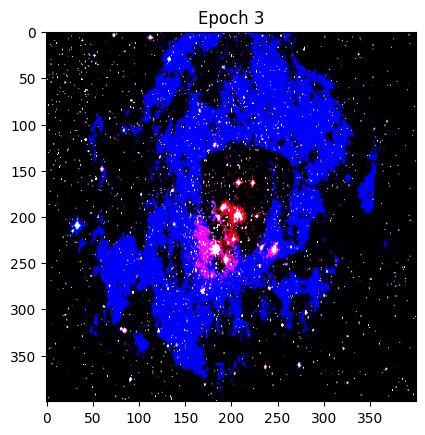

Epoch 4/10, Loss: 7.914090907807252e+17


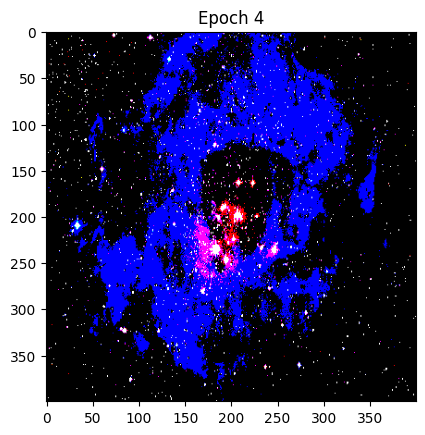

Epoch 5/10, Loss: 7.904635795003146e+17


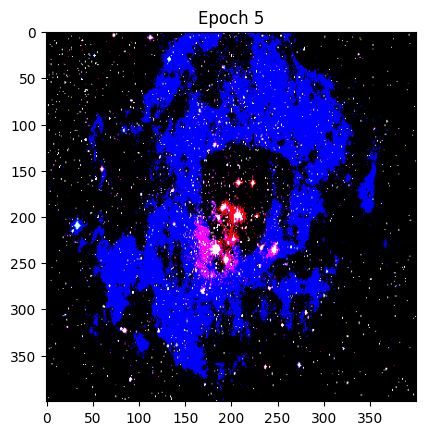

Epoch 6/10, Loss: 7.895196487678689e+17


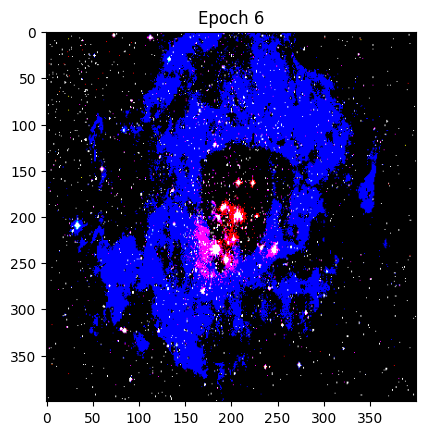

Epoch 7/10, Loss: 7.885774360223416e+17


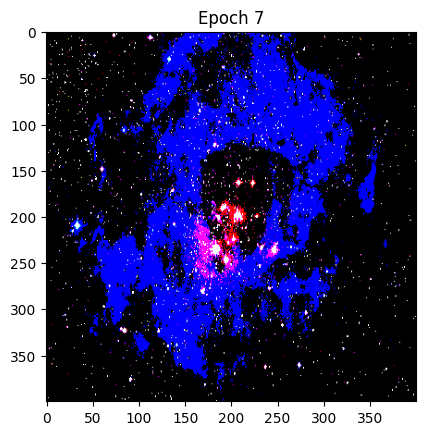

Epoch 8/10, Loss: 7.87636597666349e+17


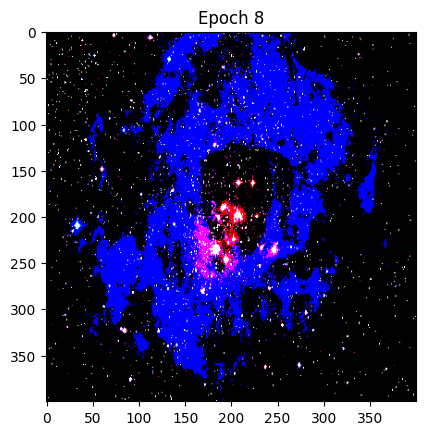

Epoch 9/10, Loss: 7.866975460167516e+17


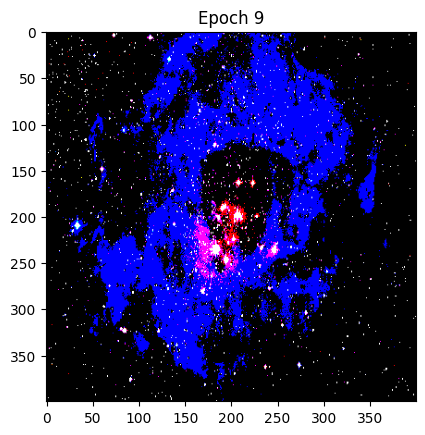

Epoch 10/10, Loss: 7.857602810735493e+17


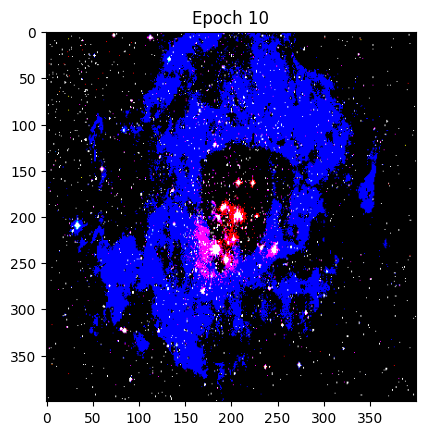

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam

# Load the content and style images
from google.colab import files
uploaded = files.upload()

# Paths to the uploaded images
content_image_path = 'content_image (2).jpg'
style_image_path = 'style_image (1).jpg'

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(400, 400))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Preprocessing for VGG19
    return img

# Load the images
content_image = load_and_preprocess_image(content_image_path)
style_image = load_and_preprocess_image(style_image_path)

# Show the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(content_image[0])
plt.title("Content Image")
plt.subplot(1, 2, 2)
plt.imshow(style_image[0])
plt.title("Style Image")
plt.show()

# Load the VGG19 model without the top layer
vgg = VGG19(include_top=False, weights='imagenet')

# Define the layers to extract features from
layer_names = ['block5_conv2', 'block4_conv2', 'block3_conv3', 'block2_conv2', 'block1_conv2']
layers = [vgg.get_layer(name).output for name in layer_names]

# Define the model for feature extraction
model = tf.keras.Model(inputs=vgg.input, outputs=layers)

# Function to get features from the model
def get_features(model, content_image, style_image):
    content_features = model(content_image)
    style_features = model(style_image)  # Directly use style_image here
    return content_features, style_features

# Function to compute gram matrix for style features
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    tensor = tf.reshape(tensor, (-1, channels))
    gram = tf.matmul(tensor, tensor, transpose_a=True)
    return gram

# Compute content and style features
content_features, style_features = get_features(model, content_image, style_image)

# Compute gram matrices for style features
style_grams = [gram_matrix(style_feature) for style_feature in style_features]

# Initialize the generated image (copy of the content image)
generated_image = tf.Variable(content_image)

# Define the loss weights
content_weight = 1e3
style_weight = 1e-2

# Function to compute total loss
def compute_loss(content_features, style_features, generated_image):
    generated_features = model(generated_image)
    content_loss = content_weight * tf.reduce_mean((generated_features[0] - content_features[0]) ** 2)

    style_loss = 0
    for gen, style in zip(generated_features, style_grams):
        style_loss += style_weight * tf.reduce_mean((gram_matrix(gen) - style) ** 2)

    total_loss = content_loss + style_loss
    return total_loss

# Optimizer
optimizer = Adam(learning_rate=0.02)

# Function to compute gradients
def compute_grads(model, content_image, style_image, generated_image):
    with tf.GradientTape() as tape:
        total_loss = compute_loss(content_features, style_features, generated_image)
    grads = tape.gradient(total_loss, generated_image)
    return grads

# Training loop
epochs = 10
for epoch in range(epochs):
    grads = compute_grads(model, content_image, style_image, generated_image)
    optimizer.apply_gradients([(grads, generated_image)])

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {compute_loss(content_features, style_features, generated_image)}")
        plt.imshow(generated_image.numpy()[0])
        plt.title(f"Epoch {epoch+1}")
        plt.show()
